In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [3]:
img = plt.imread('../docs/imgs/semantic_kitti_seqs.png')

In [4]:
img.shape

(739, 1784, 4)

In [5]:
from data.semantic_kitti import dataset_names

In [6]:
#!xrandr | grep -w connected

In [7]:
w_cm, h_cm = 34.4, 19.3
w_ic, h_ic = w_cm / 2.54, h_cm / 2.54

In [8]:
1920 / w_ic, 1080 / h_ic

(141.7674418604651, 142.13471502590673)

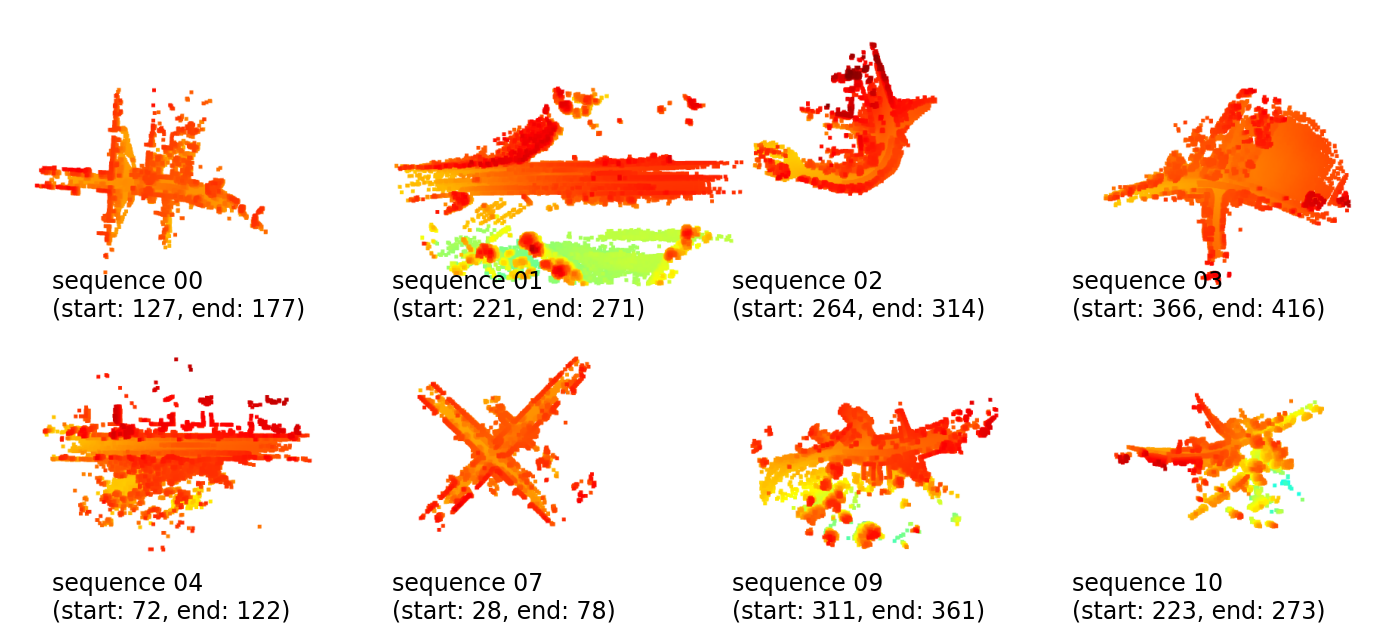

In [9]:
DPI = 142
matplotlib.rcParams.update({'font.size': 12})

plt.figure(figsize=(img.shape[1]/DPI, img.shape[0]/DPI), dpi=DPI)
# plt.grid()
plt.axis('off')
plt.imshow(img)

x, y = 50, 400
for i, name in enumerate(np.sort(dataset_names)):
    for s in ['_start_', '_end_', '_step_']:
        name = name.replace(s, '_')
    name = name[:-2]
    seq_n, start, end = name.split('_')
    name = 'sequence %s \n(start: %s, end: %s)' % (seq_n, start, end) 
    
    plt.text(x, y, name, bbox=dict(fill=False, edgecolor=None, linewidth=0))
    
    if i == len(dataset_names) / 2 - 1:
        y += 400
        x = -400
    x += 450

plt.savefig('../docs/imgs/semantic_kitti_seqs_labeled.png', dpi=DPI)

In [2]:
import torch
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

In [11]:
N = 100
z = 1.0

# pts = 10*np.random.random((N, 3))-5
pts = 10*torch.rand((3, N))-5
pts[2, :] = z

In [12]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pts.transpose(1, 0))
o3d.visualization.draw_geometries([pcd])

In [13]:
cov = torch.cov(pts)
eigvals = torch.linalg.eigvalsh(cov)

In [14]:
eigvals

tensor([0.0000, 6.5515, 9.1223])

In [15]:
torch.abs(eigvals)

tensor([0.0000, 6.5515, 9.1223])

### KITTI

In [47]:
import os
from glob import glob
import subprocess
# !pip install sh
import sh

In [43]:
#subprocess.run(["cat", "../gen/semantic_kitti_d1-25_g0.20/ground_truth_Polynomial_r0.40_none_min_eigval_loss/split_0/train_and_eval.out", "|", "grep", "saved"])

In [63]:
#out = os.system("cat '../gen/semantic_kitti_d1-25_g0.20/ground_truth_Polynomial_r0.40_none_min_eigval_loss/split_0/train_and_eval.out' | grep ') saved' | tail -n 1")

In [122]:
def plot_models(expr_dir):
    # expr_dir = '../gen/asl_laser_d1-15_g0.10'
    experiments = [e for e in os.listdir(expr_dir) if 'Polynomial' in e]
    if len(experiments) == 0:
        print('No experiments to evaluate')

    for expr in experiments:
        ps = []
        for out_file in glob('%s/%s/split_*/train_and_eval.out' % (expr_dir, expr)):
            out_str = str(sh.tail(sh.grep(sh.cat(out_file), ') saved'), '-n 1'))

            l, r = out_str.find('('), out_str.find(')')
            params = out_str[l+1:r]
            p1, p2 = params.split(',')
            p1, p2 = float(p1), float(p2)

            ps.append([p1, p2])

        angle = np.linspace(0, np.pi/2, 100)

        plt.figure()
        plt.title(expr)
        plt.grid()
        plt.xlabel('alpha, [deg]')
        plt.ylabel('depth bias')
        # plt.axis('equal')
        for p in ps:
            p1, p2 = p
            depth = 1 * (1 - p1*angle**2 - p2*angle**4)

            plt.plot(np.rad2deg(angle), depth, label='p1=%f, p2=%f'%(p1, p2))
        plt.legend()
        name = ('asl_' + expr if 'asl' in expr_dir else 'kitti_' + expr) + '.png'
        plt.savefig(name)
        plt.show()
        plt.close()

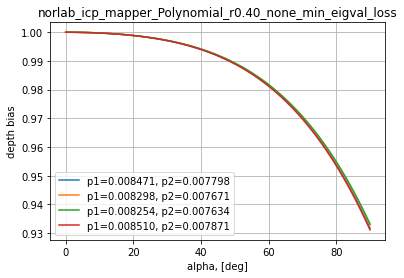

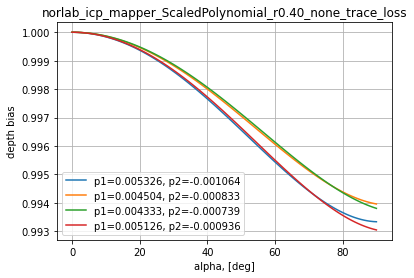

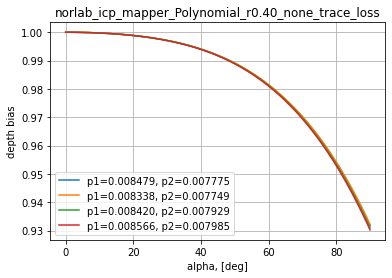

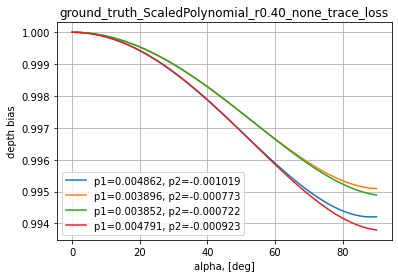

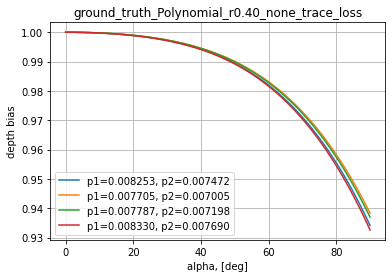

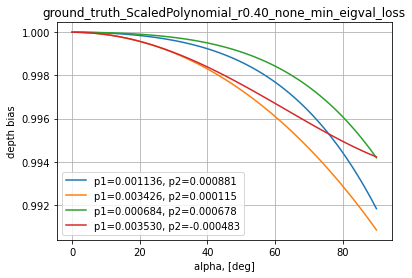

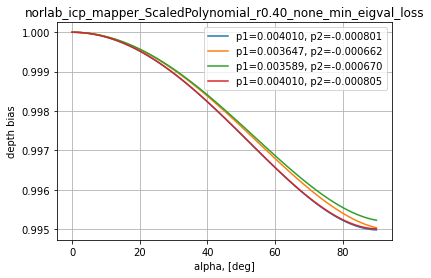

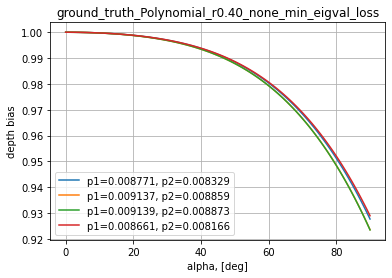

In [123]:
plot_models(expr_dir='../gen/semantic_kitti_d1-25_g0.20/')

### ASL

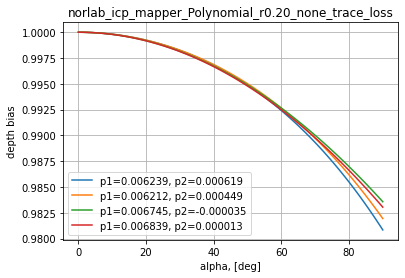

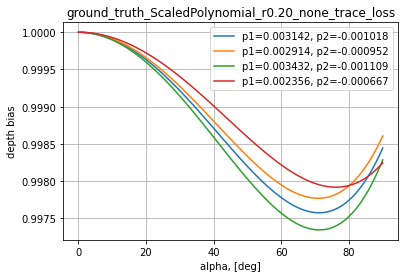

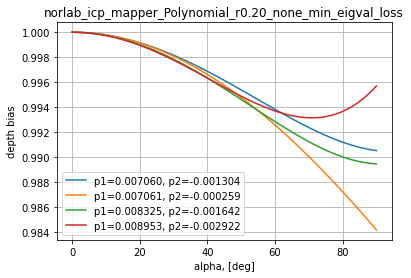

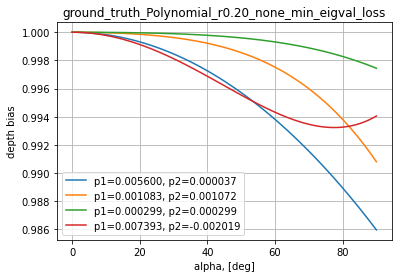

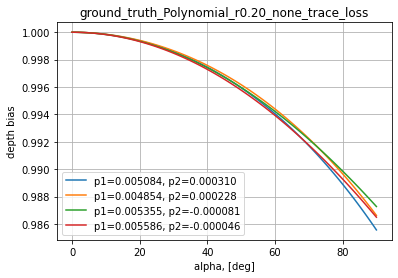

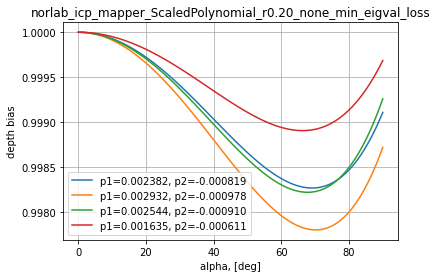

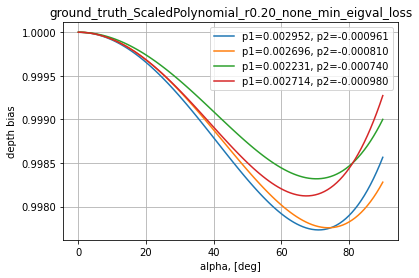

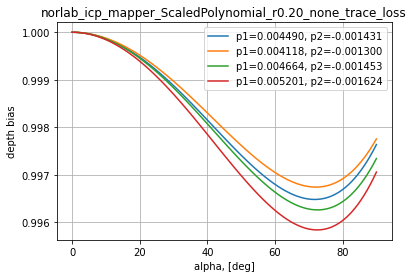

In [124]:
plot_models(expr_dir='../gen/asl_laser_d1-15_g0.10/')

In [ ]:
from depth_correction.config import Config
from depth_correction.depth_cloud import DepthCloud
from depth_correction.model import load_model
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch


def plot_models(expr_dir):
    experiments = glob(os.path.join(expr_dir, '*Polynomial*', 'split*', 'best.yaml'))
    if len(experiments) == 0:
        print('No experiments to evaluate')

    n_pts = 100
    cloud = DepthCloud.from_points(torch.ones((n_pts, 3)) / torch.sqrt(torch.tensor(3.0)))
    cloud.inc_angles = torch.as_tensor(np.linspace(0, np.pi/2, n_pts))[:, None]

    groups = {}
    group_prefix = {}
    for expr in experiments:
        path_parts = os.path.normpath(expr).split(os.path.sep)
        group = path_parts[-3]
        group_prefix[group] = os.path.join(*path_parts[:-4])
        cfg = Config()
        cfg.from_yaml(expr)
        model = load_model(cfg=cfg)
        groups.setdefault(group, []).append(model)

    print('%i groups in total.' % len(groups))
    for group, models in groups.items():
        print('%s (%i experiments)' % (group, len(models)))
        plt.figure()
        plt.title(group)
        for model in models:
            with torch.no_grad():
                plt.plot(np.rad2deg(cloud.inc_angles.numpy()).flatten(),
                         model(cloud).depth.numpy().flatten(),
                         label=str(model))
        plt.grid()
        plt.xlabel('incidence angle [deg]')
        plt.ylabel('depth [m]')
        plt.legend()
        # name = ('asl_' + expr if 'asl' in expr_dir else 'kitti_' + expr) + '.png'
        # plt.savefig(name)
        plt.show()
        # plt.close()

plot_models(expr_dir='../gen/asl_laser_d1-15_g0.10_s0.0175_0.0873-nan/')